Installazione librerie

In [ ]:
# Install libriary dependencies for running deep learning
!pip install tensorflow==2.1.0
!pip install keras==2.3.1
!pip install segmentation_models==1.0.1
!pip install h5py==2.10.0

     |████████████████████████████████| 421.8 MB 26 kB/s 
     |████████████████████████████████| 3.8 MB 45.4 MB/s 
     |████████████████████████████████| 50 kB 7.0 MB/s 
     |████████████████████████████████| 448 kB 41.1 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=acfb2df97d7ab88dcba7124479469ee170d6c81a70cd9edcc7e88b58c8c4b72f
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succes

In [ ]:
# install imagecodecs for reading masks
!pip install imagecodecs
import imagecodecs

     |████████████████████████████████| 31.0 MB 38.8 MB/s 


In [ ]:
# colab access + import libraries
from google.colab import drive
drive.mount('/content/drive')

import os
import random
import numpy as np
import plotly.express as px
import cv2

from matplotlib import pyplot as plt
from tqdm import tqdm
from skimage.io import imread, imshow, imsave

from skimage.transform import resize
from skimage import img_as_ubyte

from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

from segmentation_models import Unet

Mounted at /content/drive


Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [ ]:
# Caricamento dataset in formato .rar da Google Drive a Colab
!pip install unrar
!unrar x "/content/drive/MyDrive/eim/cytology/train.rar"     # unraring training set
!unrar x "/content/drive/MyDrive/eim/cytology/validation.rar"   # unraring validation set
!unrar x "/content/drive/MyDrive/eim/cytology/test.rar"         # unraring test set


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/eim/cytology/train.rar

Creating    train                                                     OK
Creating    train/images                                              OK
Extracting  train/images/102.tif                                           0%  OK 
Extracting  train/images/104.tif                                           0%  1%  OK 
Extracting  train/images/106.tif                                           1%  OK 
Extracting  train/images/108.tif                                           1%  2%  OK 
Extracting  train/images/109.tif                                           2%  OK 
Extracting  train/images/111.tif                                           2%  3%  OK 
Extracting  train/images/112.tif                                           3%  OK 
Extracting  train/images/114.tif                      

inizializzazione path + visualizzazione di una immagine random

there are 300 images in the training set
there are 50 images in the validation set
train_images: ['109.tif', '308.tif', '2346.tif', '2121.tif', '9293.tif', '9652.tif', '2340.tif', '1962.tif', '9484.tif', '9356.tif', '2352.tif', '1730.tif', '1819.tif', '9674.tif', '1909.tif', '9382.tif', '2081.tif', '9870.tif', '2179.tif', '1956.tif', '1985.tif', '2353.tif', '9383.tif', '9452.tif', '2393.tif', '601.tif', '9644.tif', '2196.tif', '1997.tif', '1778.tif', '2042.tif', '2085.tif', '9688.tif', '2408.tif', '2064.tif', '2328.tif', '303.tif', '213.tif', '1899.tif', '411.tif', '2336.tif', '2001.tif', '9657.tif', '2241.tif', '9877.tif', '1894.tif', '1743.tif', '2117.tif', '2005.tif', '2205.tif', '2250.tif', '2118.tif', '1991.tif', '9428.tif', '9905.tif', '2194.tif', '9422.tif', '1798.tif', '9374.tif', '1934.tif', '1966.tif', '2275.tif', '9809.tif', '2034.tif', '216.tif', '2263.tif', '9333.tif', '9660.tif', '2285.tif', '9604.tif', '9494.tif', '9784.tif', '2128.tif', '9431.tif', '106.tif', '2187.tif'

Text(0.5, 1.0, 'mask')

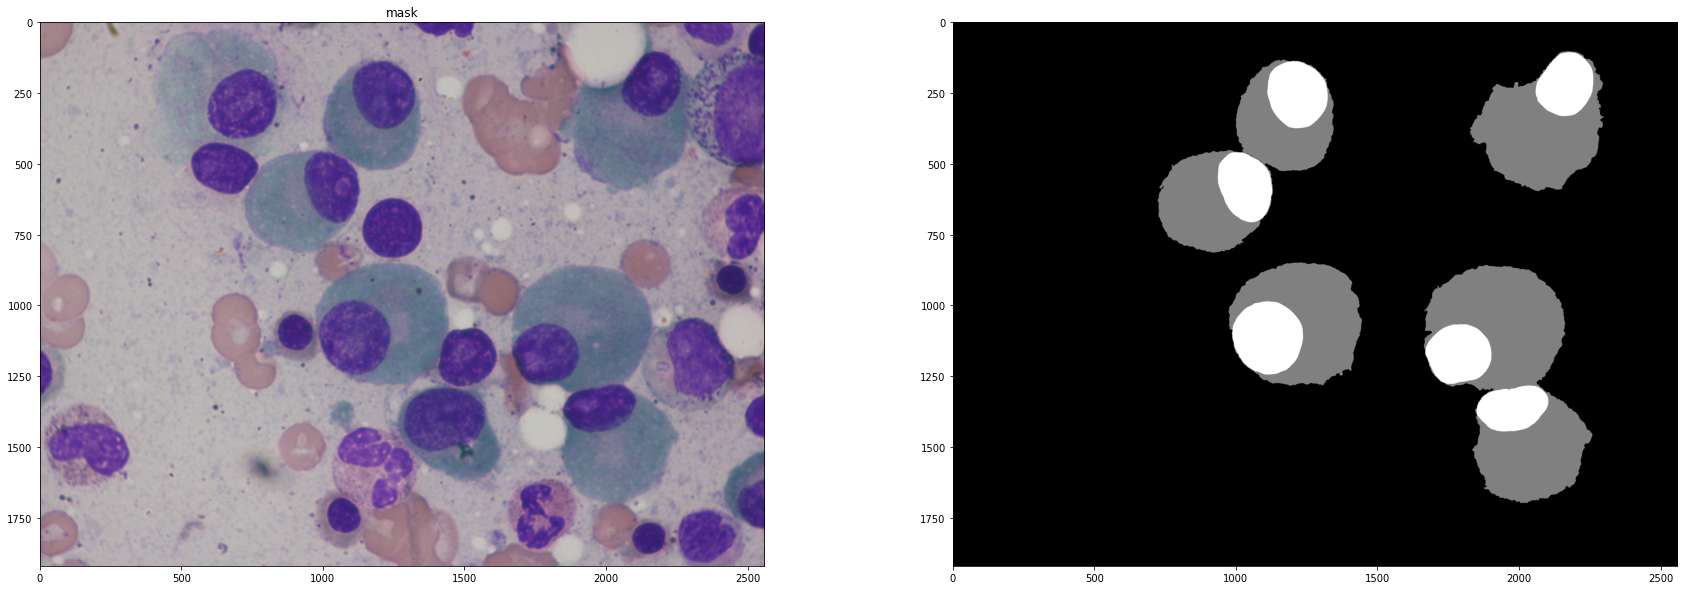

In [ ]:
# Si vuole allenare una rete che prenda in ingresso un'immagine 512x512x3 (rgb)
# e la rispettiva maschera di segmentazione (0:background, 255:lesione)
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3
NUM_CLASSES = 2

# Path
tr_IMGS_path = os.path.join('train','images')
tr_MANU_path = os.path.join('train','manual')
val_IMGS_path = os.path.join('validation', 'images')
val_MANU_path = os.path.join('validation', 'manual')

# Extracting list of images
tr_images = os.listdir(tr_IMGS_path)
val_images = os.listdir(val_IMGS_path)
print(f"there are {len(tr_images)} images in the training set")
print(f"there are {len(val_images)} images in the validation set")
print(f"train_images: {tr_images}\nval_images:{val_images}")

#estrazione causale immagine
rand_index=np.random.choice(len(tr_images))
print(f"random image: {tr_images[rand_index]})")

I = imread(os.path.join(tr_IMGS_path, tr_images[rand_index]))
mask = imagecodecs.imread(os.path.join(tr_MANU_path, tr_images[rand_index]))
print(f"mask shape: {mask.shape}")
if len(mask.shape)>2:                                 # if there is more than 1 MM cell in the current image
    mask = np.sum(mask,2,np.uint8)                    # merge the N layers segmentation in a unique greyscale image

# image + mask visualization
fig=plt.figure(figsize=(30,10))
ax1=plt.subplot(1,2,1)
ax1.imshow(I)
ax1.set_title('original image')

ax2=plt.subplot(1,2,2)
ax2.imshow(mask, cmap=plt.cm.gray)
ax1.set_title('mask')

***
***training senza preprocessing***

preparazione dataset

In [ ]:
print(len(tr_images))
dimensions=(len(tr_images),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
print(dimensions)

300
(300, 512, 512, 3)


In [ ]:
from genericpath import exists
# Creazione di una matrice 4D [#immagini, altezza, larghezza, #canali] che conterrà
# tutte le immagini di training (X_train) mentre tutte le corrispettive maschere
# di segmentazione saranno all'interno della matrice Y_train. Ragionamento analogo
# per il validation set (X_val,Y_val)
dimensions=(len(tr_images),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
mask_dimensions=(len(tr_images),IMG_HEIGHT,IMG_WIDTH,NUM_CLASSES)

# NUM_CLASSES is needed by the moment that we use "to_categorical"
# transformation (so the masks to give as input to the
# net will have 2 layers, 1 in which starting mask ones are ones
# and another in which starting mask zeros are ones)

# Inizializzazioni matrici NB: le immagini devono essere in formato uint8 mentre le maschere BW in float32
X_train = np.zeros(dimensions, dtype=np.uint8)
Y_train = np.zeros(mask_dimensions, dtype=np.float32)


for n, id_ in tqdm(enumerate(tr_images), total=len(tr_images)):

    # la variabile "n" rappresenta un contatore (0-num_immagini) mentre "id_"
    # contiene il nome della n-esima immagine

    # Lettura immagine e ricampionamento a 512x512
    fn= os.path.join(tr_IMGS_path, id_)
    img = imread(fn)
    img = resize(img, [IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS])
    img = img_as_ubyte(img) #this is needed by the moment that resize convert image in float64 format (so in range 0,1) and we are going to insert
                                    #this converted image in an uint8 array, this leading to have an image in uint8 with only zeros and ones (it would appear
                                    #black... AND IT IS A WRONG IMAGE)... an ALMOST equivalent implementation would be just setting "preserve_range" parameter
                                    #on True in skimage.resize function
    X_train[n] = img

    # Lettura maschera BW e ricampionamento maschera a 512x512
    fn1=os.path.join(tr_MANU_path, id_)
    mask = imagecodecs.imread(fn1)
    print(f"mask shape: {mask.shape}")
    dim=mask.shape
    print(dim)
    if len(dim)>2:
      if mask.shape[2]>=1:
         mask = np.sum(mask,2,np.uint8)                     # merge the N layers segmentation in a unique greyscale image

    mask = resize(mask, [IMG_HEIGHT,IMG_WIDTH], preserve_range=True)
    """
    equivalent way:
    mask = resize(mask,[IMG_HEIGHT,IMG_WIDTH], preserve_range=True) #here i did it the other way... that in this kind won't affect the results in a bay way w/
           anzichè preserved_range                                  #respect to use "skimage.img_as_ubyte" by the moment that under values near to 255 will be
           mettere [IMG_HEIGHT,IMG_WIDTH]                           #set to 1 and values near to 0 will be set to 0 and little changes as said wont't make any
                                                                  #difference given the threshold of 127 (contest:notice that the masks originally were in uint8
                                                                  #data format w/ NOT SEGMENTED set to 0 and SEGMENTED set to 255)
    """
    mask[mask<127] = 0
    mask[mask>=127] = 1

    # Conversione della maschera in dato categorico
    mask = to_categorical(mask, num_classes=NUM_CLASSES, dtype='float32') #I think this makes a category for each possible value/level (prof said this is
                                                                          #needed to use the keras DL framework[i.e. it is implemented to perform well on
                                                                          #masks in this datatype] --> this due to the fact that open sources Python library
                                                                          #being open sources are implemented for general purpose and not specificly for
                                                                          #medical purpose, so in general purpose world problem classes may be easily bigger
                                                                          #than 2 and for this reason a layer for each class is needed... this also explains
                                                                          #why data format of mask is needed to be float32 for the implementation: considering
                                                                          #general purpose problems in which classes can also be bigger than 256 a float32
                                                                          #codification is required) in the pixels of the image (in our case).
                                                                          #
                                                                          #Also parameter "dtype" set to float32 is quite useless btm that this is done by
                                                                          #default.
    Y_train[n] = mask



  0%|          | 0/300 [00:00<?, ?it/s]

mask shape: (1920, 2560, 5)
(1920, 2560, 5)


  0%|          | 1/300 [00:01<07:19,  1.47s/it]

mask shape: (1920, 2560, 7)
(1920, 2560, 7)


  1%|          | 3/300 [00:03<05:27,  1.10s/it]

mask shape: (1536, 2040, 10)
(1536, 2040, 10)


  1%|▏         | 4/300 [00:04<05:00,  1.01s/it]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


  2%|▏         | 5/300 [00:05<04:28,  1.10it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


  2%|▏         | 6/300 [00:05<04:02,  1.21it/s]

mask shape: (1536, 2040)
(1536, 2040)


  2%|▏         | 7/300 [00:06<04:08,  1.18it/s]

mask shape: (1536, 2040, 12)
(1536, 2040, 12)


  3%|▎         | 8/300 [00:07<04:00,  1.21it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)


  3%|▎         | 9/300 [00:08<03:49,  1.27it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)


  3%|▎         | 10/300 [00:08<03:50,  1.26it/s]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


  4%|▎         | 11/300 [00:09<03:44,  1.28it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)


  4%|▍         | 12/300 [00:10<03:46,  1.27it/s]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


  4%|▍         | 13/300 [00:11<03:46,  1.27it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


  5%|▍         | 14/300 [00:12<03:51,  1.23it/s]

mask shape: (1536, 2040, 10)
(1536, 2040, 10)


  5%|▌         | 15/300 [00:13<04:03,  1.17it/s]

mask shape: (1536, 2040, 12)
(1536, 2040, 12)


  5%|▌         | 16/300 [00:13<03:51,  1.23it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)


  6%|▌         | 17/300 [00:14<03:53,  1.21it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


  6%|▌         | 18/300 [00:15<03:42,  1.27it/s]

mask shape: (1536, 2040, 2)
(1536, 2040, 2)


  6%|▋         | 19/300 [00:16<03:49,  1.22it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


  7%|▋         | 20/300 [00:17<03:39,  1.28it/s]

mask shape: (1536, 2040)
(1536, 2040)


  7%|▋         | 21/300 [00:17<03:40,  1.27it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


  7%|▋         | 22/300 [00:18<03:41,  1.26it/s]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)


  8%|▊         | 23/300 [00:19<03:34,  1.29it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)


  8%|▊         | 24/300 [00:20<03:30,  1.31it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


  8%|▊         | 25/300 [00:20<03:34,  1.28it/s]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)
mask shape: (1920, 2560, 3)
(1920, 2560, 3)


  9%|▉         | 27/300 [00:22<03:46,  1.21it/s]

mask shape: (1536, 2040, 2)
(1536, 2040, 2)


  9%|▉         | 28/300 [00:23<03:47,  1.20it/s]

mask shape: (1536, 2040, 9)
(1536, 2040, 9)


 10%|▉         | 29/300 [00:24<03:31,  1.28it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)


 10%|█         | 30/300 [00:24<03:25,  1.31it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


 10%|█         | 31/300 [00:25<03:25,  1.31it/s]

mask shape: (1536, 2040, 9)
(1536, 2040, 9)


 11%|█         | 32/300 [00:26<03:29,  1.28it/s]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


 11%|█         | 33/300 [00:27<03:17,  1.35it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


 11%|█▏        | 34/300 [00:27<03:11,  1.39it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 12%|█▏        | 35/300 [00:28<03:09,  1.40it/s]

mask shape: (1536, 2040, 2)
(1536, 2040, 2)


 12%|█▏        | 36/300 [00:29<03:13,  1.37it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)
mask shape: (1920, 2560, 5)
(1920, 2560, 5)


 12%|█▏        | 37/300 [00:30<03:52,  1.13it/s]

mask shape: (1920, 2560, 6)
(1920, 2560, 6)


 13%|█▎        | 39/300 [00:32<03:56,  1.11it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)
mask shape: (1920, 2560)
(1920, 2560)


 14%|█▎        | 41/300 [00:34<03:44,  1.15it/s]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


 14%|█▍        | 42/300 [00:34<03:30,  1.23it/s]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


 14%|█▍        | 43/300 [00:35<03:14,  1.32it/s]

mask shape: (1536, 2040)
(1536, 2040)


 15%|█▍        | 44/300 [00:36<03:07,  1.37it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 15%|█▌        | 45/300 [00:36<03:03,  1.39it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)


 15%|█▌        | 46/300 [00:37<03:05,  1.37it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)


 16%|█▌        | 47/300 [00:38<03:04,  1.37it/s]

mask shape: (1536, 2040, 2)
(1536, 2040, 2)


 16%|█▌        | 48/300 [00:39<03:14,  1.30it/s]

mask shape: (1536, 2040, 10)
(1536, 2040, 10)


 16%|█▋        | 49/300 [00:39<03:13,  1.30it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


 17%|█▋        | 50/300 [00:40<03:15,  1.28it/s]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)


 17%|█▋        | 51/300 [00:41<03:23,  1.23it/s]

mask shape: (1536, 2040, 9)
(1536, 2040, 9)


 17%|█▋        | 52/300 [00:42<03:21,  1.23it/s]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


 18%|█▊        | 53/300 [00:43<03:25,  1.20it/s]

mask shape: (1536, 2040, 12)
(1536, 2040, 12)


 18%|█▊        | 54/300 [00:44<03:15,  1.26it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)


 18%|█▊        | 55/300 [00:44<03:11,  1.28it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


 19%|█▊        | 56/300 [00:45<03:11,  1.27it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


 19%|█▉        | 57/300 [00:46<03:06,  1.31it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 19%|█▉        | 58/300 [00:47<03:08,  1.28it/s]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)


 20%|█▉        | 59/300 [00:47<03:02,  1.32it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)


 20%|██        | 60/300 [00:48<03:05,  1.29it/s]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


 20%|██        | 61/300 [00:49<03:04,  1.30it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


 21%|██        | 62/300 [00:50<03:05,  1.29it/s]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


 21%|██        | 63/300 [00:50<02:59,  1.32it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 21%|██▏       | 64/300 [00:51<02:53,  1.36it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)
mask shape: (1920, 2560, 4)
(1920, 2560, 4)


 22%|██▏       | 66/300 [00:53<03:24,  1.15it/s]

mask shape: (1536, 2040, 11)
(1536, 2040, 11)


 22%|██▏       | 67/300 [00:54<03:16,  1.19it/s]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


 23%|██▎       | 68/300 [00:55<03:07,  1.24it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


 23%|██▎       | 69/300 [00:55<03:06,  1.24it/s]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)


 23%|██▎       | 70/300 [00:56<02:57,  1.29it/s]

mask shape: (1536, 2040, 2)
(1536, 2040, 2)


 24%|██▎       | 71/300 [00:57<02:47,  1.37it/s]

mask shape: (1536, 2040)
(1536, 2040)


 24%|██▍       | 72/300 [00:58<02:45,  1.38it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)


 24%|██▍       | 73/300 [00:58<02:54,  1.30it/s]

mask shape: (1536, 2040, 10)
(1536, 2040, 10)


 25%|██▍       | 74/300 [00:59<02:53,  1.30it/s]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)
mask shape: (1920, 2560, 5)
(1920, 2560, 5)


 25%|██▌       | 76/300 [01:01<03:21,  1.11it/s]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)


 26%|██▌       | 77/300 [01:02<03:05,  1.20it/s]

mask shape: (1536, 2040, 2)
(1536, 2040, 2)


 26%|██▌       | 78/300 [01:03<02:58,  1.24it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


 26%|██▋       | 79/300 [01:04<02:57,  1.24it/s]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


 27%|██▋       | 80/300 [01:04<03:01,  1.21it/s]

mask shape: (1536, 2040, 11)
(1536, 2040, 11)


 27%|██▋       | 81/300 [01:05<02:55,  1.25it/s]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


 27%|██▋       | 82/300 [01:06<02:56,  1.24it/s]

mask shape: (1536, 2040, 9)
(1536, 2040, 9)
mask shape: (1920, 2560, 2)
(1920, 2560, 2)


 28%|██▊       | 84/300 [01:08<03:06,  1.16it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)


 28%|██▊       | 85/300 [01:09<03:01,  1.19it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


 29%|██▊       | 86/300 [01:10<02:58,  1.20it/s]

mask shape: (1536, 2040, 11)
(1536, 2040, 11)


 29%|██▉       | 87/300 [01:10<02:51,  1.24it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)
mask shape: (1920, 2560, 2)
(1920, 2560, 2)


 30%|██▉       | 89/300 [01:12<03:08,  1.12it/s]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


 30%|███       | 90/300 [01:13<03:08,  1.11it/s]

mask shape: (1536, 2040, 14)
(1536, 2040, 14)


 30%|███       | 91/300 [01:14<03:01,  1.15it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


 31%|███       | 92/300 [01:15<02:50,  1.22it/s]

mask shape: (1536, 2040)
(1536, 2040)


 31%|███       | 93/300 [01:16<02:53,  1.19it/s]

mask shape: (1536, 2040, 11)
(1536, 2040, 11)
mask shape: (1536, 2040, 9)
(1536, 2040, 9)


 32%|███▏      | 95/300 [01:17<03:00,  1.13it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


 32%|███▏      | 96/300 [01:18<02:57,  1.15it/s]

mask shape: (1536, 2040, 10)
(1536, 2040, 10)


 32%|███▏      | 97/300 [01:19<02:51,  1.18it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


 33%|███▎      | 98/300 [01:20<02:46,  1.21it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


 33%|███▎      | 99/300 [01:21<02:37,  1.27it/s]

mask shape: (1536, 2040, 2)
(1536, 2040, 2)


 33%|███▎      | 100/300 [01:21<02:35,  1.29it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 34%|███▎      | 101/300 [01:22<02:38,  1.26it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


 34%|███▍      | 102/300 [01:23<02:31,  1.31it/s]

mask shape: (1536, 2040, 2)
(1536, 2040, 2)


 34%|███▍      | 103/300 [01:24<02:29,  1.32it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


 35%|███▍      | 104/300 [01:24<02:31,  1.30it/s]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)
mask shape: (1920, 2560, 4)
(1920, 2560, 4)


 35%|███▌      | 106/300 [01:26<02:49,  1.15it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 36%|███▌      | 107/300 [01:27<02:47,  1.15it/s]

mask shape: (1536, 2040, 9)
(1536, 2040, 9)


 36%|███▌      | 108/300 [01:28<02:43,  1.17it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


 36%|███▋      | 109/300 [01:29<02:38,  1.20it/s]

mask shape: (1536, 2040, 9)
(1536, 2040, 9)


 37%|███▋      | 110/300 [01:30<02:35,  1.22it/s]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


 37%|███▋      | 111/300 [01:30<02:33,  1.23it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


 37%|███▋      | 112/300 [01:31<02:28,  1.27it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 38%|███▊      | 113/300 [01:32<02:27,  1.27it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


 38%|███▊      | 114/300 [01:33<02:19,  1.33it/s]

mask shape: (1536, 2040)
(1536, 2040)


 38%|███▊      | 115/300 [01:33<02:21,  1.31it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)
mask shape: (1536, 2040, 5)
(1536, 2040, 5)


 39%|███▉      | 117/300 [01:35<02:35,  1.17it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


 39%|███▉      | 118/300 [01:36<02:33,  1.19it/s]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)
mask shape: (1920, 2560, 2)
(1920, 2560, 2)


 40%|████      | 120/300 [01:38<02:40,  1.12it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


 40%|████      | 121/300 [01:39<02:31,  1.18it/s]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)


 41%|████      | 122/300 [01:40<02:24,  1.23it/s]

mask shape: (1536, 2040, 2)
(1536, 2040, 2)


 41%|████      | 123/300 [01:41<02:28,  1.20it/s]

mask shape: (1536, 2040, 12)
(1536, 2040, 12)


 41%|████▏     | 124/300 [01:41<02:20,  1.25it/s]

mask shape: (1536, 2040, 2)
(1536, 2040, 2)
mask shape: (1920, 2560, 6)
(1920, 2560, 6)


 42%|████▏     | 125/300 [01:43<02:45,  1.06it/s]

mask shape: (1920, 2560, 9)
(1920, 2560, 9)


 42%|████▏     | 127/300 [01:45<02:51,  1.01it/s]

mask shape: (1536, 2040, 9)
(1536, 2040, 9)


 43%|████▎     | 128/300 [01:46<02:43,  1.05it/s]

mask shape: (1536, 2040, 9)
(1536, 2040, 9)


 43%|████▎     | 129/300 [01:46<02:27,  1.16it/s]

mask shape: (1536, 2040)
(1536, 2040)


 43%|████▎     | 130/300 [01:47<02:21,  1.20it/s]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


 44%|████▎     | 131/300 [01:48<02:20,  1.21it/s]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)


 44%|████▍     | 132/300 [01:48<02:11,  1.28it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)
mask shape: (1920, 2560, 5)
(1920, 2560, 5)


 45%|████▍     | 134/300 [01:51<02:28,  1.11it/s]

mask shape: (1536, 2040, 10)
(1536, 2040, 10)


 45%|████▌     | 135/300 [01:51<02:19,  1.19it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)
mask shape: (1920, 2560, 4)
(1920, 2560, 4)


 46%|████▌     | 137/300 [01:53<02:26,  1.11it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 46%|████▌     | 138/300 [01:54<02:19,  1.16it/s]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)
mask shape: (1920, 2560, 4)
(1920, 2560, 4)


 47%|████▋     | 140/300 [01:56<02:28,  1.08it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


 47%|████▋     | 141/300 [01:57<02:17,  1.16it/s]

mask shape: (1536, 2040, 2)
(1536, 2040, 2)


 47%|████▋     | 142/300 [01:58<02:16,  1.15it/s]

mask shape: (1536, 2040, 11)
(1536, 2040, 11)


 48%|████▊     | 143/300 [01:58<02:12,  1.19it/s]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


 48%|████▊     | 144/300 [01:59<02:06,  1.23it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)


 48%|████▊     | 145/300 [02:00<01:57,  1.32it/s]

mask shape: (1536, 2040)
(1536, 2040)


 49%|████▊     | 146/300 [02:01<01:58,  1.30it/s]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


 49%|████▉     | 147/300 [02:01<01:57,  1.31it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


 49%|████▉     | 148/300 [02:02<01:58,  1.28it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


 50%|████▉     | 149/300 [02:03<01:55,  1.31it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


 50%|█████     | 150/300 [02:04<01:54,  1.31it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 50%|█████     | 151/300 [02:04<01:53,  1.31it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


 51%|█████     | 152/300 [02:05<01:49,  1.35it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)


 51%|█████     | 153/300 [02:06<01:45,  1.39it/s]

mask shape: (1536, 2040)
(1536, 2040)


 51%|█████▏    | 154/300 [02:06<01:43,  1.41it/s]

mask shape: (1536, 2040, 2)
(1536, 2040, 2)


 52%|█████▏    | 155/300 [02:07<01:38,  1.47it/s]

mask shape: (1536, 2040)
(1536, 2040)


 52%|█████▏    | 156/300 [02:08<01:40,  1.44it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


 52%|█████▏    | 157/300 [02:09<01:41,  1.41it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


 53%|█████▎    | 158/300 [02:09<01:48,  1.31it/s]

mask shape: (1536, 2040, 12)
(1536, 2040, 12)


 53%|█████▎    | 159/300 [02:10<01:47,  1.32it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


 53%|█████▎    | 160/300 [02:11<01:50,  1.27it/s]

mask shape: (1536, 2040, 12)
(1536, 2040, 12)


 54%|█████▎    | 161/300 [02:12<01:48,  1.29it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 54%|█████▍    | 162/300 [02:13<01:43,  1.33it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)
mask shape: (1536, 2040, 7)
(1536, 2040, 7)


 54%|█████▍    | 163/300 [02:14<01:53,  1.21it/s]

mask shape: (1920, 2560, 2)
(1920, 2560, 2)


 55%|█████▍    | 164/300 [02:16<02:43,  1.20s/it]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 55%|█████▌    | 165/300 [02:17<02:41,  1.20s/it]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)


 56%|█████▌    | 167/300 [02:19<02:43,  1.23s/it]

mask shape: (1536, 2040, 10)
(1536, 2040, 10)


 56%|█████▌    | 168/300 [02:20<02:23,  1.08s/it]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 56%|█████▋    | 169/300 [02:21<02:11,  1.00s/it]

mask shape: (1536, 2040, 9)
(1536, 2040, 9)


 57%|█████▋    | 170/300 [02:22<02:02,  1.06it/s]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


 57%|█████▋    | 171/300 [02:23<01:57,  1.10it/s]

mask shape: (1536, 2040, 9)
(1536, 2040, 9)


 57%|█████▋    | 172/300 [02:23<01:49,  1.17it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)


 58%|█████▊    | 173/300 [02:24<01:41,  1.25it/s]

mask shape: (1536, 2040, 2)
(1536, 2040, 2)


 58%|█████▊    | 174/300 [02:25<01:38,  1.28it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)


 58%|█████▊    | 175/300 [02:25<01:36,  1.29it/s]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


 59%|█████▊    | 176/300 [02:26<01:30,  1.38it/s]

mask shape: (1536, 2040)
(1536, 2040)


 59%|█████▉    | 177/300 [02:27<01:30,  1.36it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


 59%|█████▉    | 178/300 [02:28<01:33,  1.31it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


 60%|█████▉    | 179/300 [02:28<01:30,  1.33it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 60%|██████    | 180/300 [02:29<01:31,  1.30it/s]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)


 60%|██████    | 181/300 [02:30<01:30,  1.31it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 61%|██████    | 182/300 [02:31<01:30,  1.30it/s]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)


 61%|██████    | 183/300 [02:31<01:27,  1.33it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 61%|██████▏   | 184/300 [02:32<01:29,  1.30it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


 62%|██████▏   | 185/300 [02:33<01:26,  1.34it/s]

mask shape: (1536, 2040, 2)
(1536, 2040, 2)


 62%|██████▏   | 186/300 [02:34<01:22,  1.38it/s]

mask shape: (1536, 2040, 2)
(1536, 2040, 2)
mask shape: (1920, 2560, 4)
(1920, 2560, 4)


 63%|██████▎   | 188/300 [02:36<01:30,  1.24it/s]

mask shape: (1536, 2040)
(1536, 2040)
mask shape: (1920, 2560, 5)
(1920, 2560, 5)


 63%|██████▎   | 189/300 [02:37<01:45,  1.05it/s]

mask shape: (1920, 2560, 4)
(1920, 2560, 4)


 64%|██████▎   | 191/300 [02:39<01:48,  1.00it/s]

mask shape: (1536, 2040, 10)
(1536, 2040, 10)


 64%|██████▍   | 192/300 [02:40<01:43,  1.04it/s]

mask shape: (1536, 2040, 12)
(1536, 2040, 12)
mask shape: (1920, 2560, 2)
(1920, 2560, 2)


 65%|██████▍   | 194/300 [02:42<01:43,  1.02it/s]

mask shape: (1536, 2040, 9)
(1536, 2040, 9)


 65%|██████▌   | 195/300 [02:43<01:38,  1.07it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


 65%|██████▌   | 196/300 [02:43<01:31,  1.14it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)


 66%|██████▌   | 197/300 [02:44<01:26,  1.19it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


 66%|██████▌   | 198/300 [02:45<01:21,  1.25it/s]

mask shape: (1536, 2040, 2)
(1536, 2040, 2)
mask shape: (1920, 2560, 2)
(1920, 2560, 2)


 67%|██████▋   | 200/300 [02:47<01:24,  1.18it/s]

mask shape: (1536, 2040)
(1536, 2040)


 67%|██████▋   | 201/300 [02:48<01:22,  1.21it/s]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)


 67%|██████▋   | 202/300 [02:48<01:18,  1.25it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 68%|██████▊   | 203/300 [02:49<01:18,  1.24it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


 68%|██████▊   | 204/300 [02:50<01:17,  1.23it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


 68%|██████▊   | 205/300 [02:51<01:15,  1.26it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 69%|██████▊   | 206/300 [02:51<01:10,  1.34it/s]

mask shape: (1536, 2040)
(1536, 2040)


 69%|██████▉   | 207/300 [02:52<01:11,  1.31it/s]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)


 69%|██████▉   | 208/300 [02:53<01:11,  1.29it/s]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


 70%|██████▉   | 209/300 [02:54<01:11,  1.27it/s]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


 70%|███████   | 210/300 [02:54<01:08,  1.31it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)


 70%|███████   | 211/300 [02:55<01:09,  1.29it/s]

mask shape: (1536, 2040, 9)
(1536, 2040, 9)


 71%|███████   | 212/300 [02:56<01:09,  1.27it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


 71%|███████   | 213/300 [02:57<01:07,  1.29it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


 71%|███████▏  | 214/300 [02:58<01:05,  1.30it/s]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)


 72%|███████▏  | 215/300 [02:58<01:04,  1.32it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 72%|███████▏  | 216/300 [02:59<01:02,  1.34it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 72%|███████▏  | 217/300 [03:00<01:04,  1.28it/s]

mask shape: (1536, 2040, 11)
(1536, 2040, 11)


 73%|███████▎  | 218/300 [03:01<01:04,  1.27it/s]

mask shape: (1536, 2040, 11)
(1536, 2040, 11)


 73%|███████▎  | 219/300 [03:01<01:02,  1.30it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)
mask shape: (1920, 2560, 4)
(1920, 2560, 4)


 74%|███████▎  | 221/300 [03:03<01:07,  1.17it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 74%|███████▍  | 222/300 [03:04<01:04,  1.21it/s]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


 74%|███████▍  | 223/300 [03:05<00:59,  1.29it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)


 75%|███████▍  | 224/300 [03:06<01:01,  1.24it/s]

mask shape: (1536, 2040, 12)
(1536, 2040, 12)


 75%|███████▌  | 225/300 [03:06<00:58,  1.28it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


 75%|███████▌  | 226/300 [03:07<00:56,  1.31it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)
mask shape: (1920, 2560, 8)
(1920, 2560, 8)


 76%|███████▌  | 228/300 [03:09<01:01,  1.16it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)
mask shape: (1920, 2560, 5)
(1920, 2560, 5)


 76%|███████▋  | 229/300 [03:10<01:09,  1.02it/s]

mask shape: (1920, 2560, 6)
(1920, 2560, 6)


 77%|███████▋  | 231/300 [03:12<01:08,  1.01it/s]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


 77%|███████▋  | 232/300 [03:13<01:01,  1.10it/s]

mask shape: (1536, 2040, 2)
(1536, 2040, 2)


 78%|███████▊  | 233/300 [03:14<00:57,  1.17it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 78%|███████▊  | 234/300 [03:15<00:52,  1.26it/s]

mask shape: (1536, 2040)
(1536, 2040)


 78%|███████▊  | 235/300 [03:15<00:53,  1.22it/s]

mask shape: (1536, 2040, 10)
(1536, 2040, 10)


 79%|███████▊  | 236/300 [03:16<00:50,  1.26it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)


 79%|███████▉  | 237/300 [03:17<00:50,  1.25it/s]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


 79%|███████▉  | 238/300 [03:18<00:49,  1.26it/s]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)


 80%|███████▉  | 239/300 [03:19<00:50,  1.22it/s]

mask shape: (1536, 2040, 12)
(1536, 2040, 12)


 80%|████████  | 240/300 [03:20<00:49,  1.21it/s]

mask shape: (1536, 2040, 10)
(1536, 2040, 10)


 80%|████████  | 241/300 [03:20<00:46,  1.26it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 81%|████████  | 242/300 [03:21<00:44,  1.30it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 81%|████████  | 243/300 [03:22<00:42,  1.33it/s]

mask shape: (1536, 2040, 2)
(1536, 2040, 2)
mask shape: (1920, 2560, 3)
(1920, 2560, 3)


 81%|████████▏ | 244/300 [03:23<00:50,  1.11it/s]

mask shape: (1920, 2560, 3)
(1920, 2560, 3)


 82%|████████▏ | 246/300 [03:25<00:53,  1.02it/s]

mask shape: (1536, 2040, 2)
(1536, 2040, 2)


 82%|████████▏ | 247/300 [03:26<00:51,  1.04it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


 83%|████████▎ | 248/300 [03:27<00:48,  1.08it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


 83%|████████▎ | 249/300 [03:28<00:44,  1.15it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)
mask shape: (1920, 2560, 2)
(1920, 2560, 2)


 84%|████████▎ | 251/300 [03:30<00:44,  1.10it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)


 84%|████████▍ | 252/300 [03:30<00:41,  1.15it/s]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)


 84%|████████▍ | 253/300 [03:31<00:40,  1.17it/s]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)


 85%|████████▍ | 254/300 [03:32<00:38,  1.19it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


 85%|████████▌ | 255/300 [03:33<00:41,  1.07it/s]

mask shape: (1920, 2560)
(1920, 2560)


 85%|████████▌ | 256/300 [03:34<00:38,  1.13it/s]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


 86%|████████▌ | 257/300 [03:35<00:35,  1.22it/s]

mask shape: (1536, 2040, 2)
(1536, 2040, 2)


 86%|████████▌ | 258/300 [03:35<00:34,  1.21it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


 86%|████████▋ | 259/300 [03:36<00:31,  1.28it/s]

mask shape: (1536, 2040)
(1536, 2040)


 87%|████████▋ | 260/300 [03:37<00:31,  1.26it/s]

mask shape: (1536, 2040, 9)
(1536, 2040, 9)


 87%|████████▋ | 261/300 [03:38<00:31,  1.26it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


 87%|████████▋ | 262/300 [03:38<00:29,  1.28it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 88%|████████▊ | 263/300 [03:39<00:27,  1.34it/s]

mask shape: (1536, 2040)
(1536, 2040)


 88%|████████▊ | 264/300 [03:40<00:26,  1.38it/s]

mask shape: (1536, 2040, 2)
(1536, 2040, 2)


 88%|████████▊ | 265/300 [03:41<00:26,  1.34it/s]

mask shape: (1536, 2040, 9)
(1536, 2040, 9)


 89%|████████▊ | 266/300 [03:41<00:26,  1.30it/s]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)


 89%|████████▉ | 267/300 [03:42<00:25,  1.31it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 89%|████████▉ | 268/300 [03:43<00:24,  1.30it/s]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)


 90%|████████▉ | 269/300 [03:44<00:25,  1.24it/s]

mask shape: (1536, 2040, 12)
(1536, 2040, 12)


 90%|█████████ | 270/300 [03:45<00:23,  1.28it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)
mask shape: (1920, 2560, 2)
(1920, 2560, 2)


 91%|█████████ | 272/300 [03:47<00:25,  1.10it/s]

mask shape: (1536, 2040, 14)
(1536, 2040, 14)


 91%|█████████ | 273/300 [03:47<00:22,  1.18it/s]

mask shape: (1536, 2040, 2)
(1536, 2040, 2)
mask shape: (1920, 2560, 4)
(1920, 2560, 4)


 91%|█████████▏| 274/300 [03:49<00:25,  1.03it/s]

mask shape: (1920, 2560, 2)
(1920, 2560, 2)


 92%|█████████▏| 276/300 [03:51<00:23,  1.02it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


 92%|█████████▏| 277/300 [03:52<00:21,  1.09it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 93%|█████████▎| 278/300 [03:52<00:19,  1.13it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


 93%|█████████▎| 279/300 [03:53<00:18,  1.17it/s]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)


 93%|█████████▎| 280/300 [03:54<00:16,  1.20it/s]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


 94%|█████████▎| 281/300 [03:55<00:15,  1.23it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


 94%|█████████▍| 282/300 [03:55<00:14,  1.23it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


 94%|█████████▍| 283/300 [03:56<00:13,  1.26it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


 95%|█████████▍| 284/300 [03:57<00:13,  1.22it/s]

mask shape: (1536, 2040, 10)
(1536, 2040, 10)


 95%|█████████▌| 285/300 [03:58<00:11,  1.27it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)


 95%|█████████▌| 286/300 [03:58<00:10,  1.33it/s]

mask shape: (1536, 2040)
(1536, 2040)


 96%|█████████▌| 287/300 [03:59<00:09,  1.35it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)


 96%|█████████▌| 288/300 [04:00<00:09,  1.30it/s]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)
mask shape: (1920, 2560, 5)
(1920, 2560, 5)


 97%|█████████▋| 290/300 [04:02<00:09,  1.09it/s]

mask shape: (1536, 2040, 12)
(1536, 2040, 12)


 97%|█████████▋| 291/300 [04:03<00:07,  1.13it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


 97%|█████████▋| 292/300 [04:04<00:06,  1.15it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


 98%|█████████▊| 293/300 [04:05<00:05,  1.22it/s]

mask shape: (1536, 2040, 2)
(1536, 2040, 2)


 98%|█████████▊| 294/300 [04:05<00:04,  1.24it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


 98%|█████████▊| 295/300 [04:06<00:04,  1.24it/s]

mask shape: (1536, 2040, 9)
(1536, 2040, 9)


 99%|█████████▊| 296/300 [04:07<00:03,  1.30it/s]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)


 99%|█████████▉| 297/300 [04:08<00:02,  1.31it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 99%|█████████▉| 298/300 [04:08<00:01,  1.31it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


100%|█████████▉| 299/300 [04:09<00:00,  1.31it/s]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


100%|██████████| 300/300 [04:10<00:00,  1.20it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


In [ ]:
# Creazione matrici per validation set
dimensions=(len(val_images),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
mask_dimensions=(len(val_images),IMG_HEIGHT,IMG_WIDTH,NUM_CLASSES)
# Inizializzazioni matrici
X_val = np.zeros(dimensions, dtype=np.uint8)
Y_val = np.zeros(mask_dimensions, dtype=np.float32)

for n, id_ in tqdm(enumerate(val_images), total=len(val_images)):
    # Lettura immagine e ricampionamento a 512x512
    fn=os.path.join(val_IMGS_path, id_)
    img = imread(fn)
    img = resize(img, [IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS])
    img = img_as_ubyte(img)
    X_val[n] = img

    # Lettura maschera BW e ricampionamento maschera a 512x512
    fn1=os.path.join(val_MANU_path, id_)
    mask = imagecodecs.imread(fn1)
    print(f"mask shape: {mask.shape}")
    dim=mask.shape
    print(dim)
    if len(dim)>2:
      if mask.shape[2]>=1:
         mask = np.sum(mask,2,np.uint8)                     # merge the N layers segmentation in a unique greyscale image

    mask = resize(mask, [IMG_HEIGHT,IMG_WIDTH], preserve_range=True)

    mask[mask<127] = 0
    mask[mask>=127] = 1

    # Conversione della maschera in dato categorico
    mask = to_categorical(mask, num_classes=NUM_CLASSES, dtype='float32')
    Y_val[n] = mask

  2%|▏         | 1/50 [00:00<00:35,  1.38it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)


  4%|▍         | 2/50 [00:01<00:31,  1.54it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)
mask shape: (1920, 2560, 7)
(1920, 2560, 7)


  8%|▊         | 4/50 [00:03<00:42,  1.08it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)
mask shape: (1920, 2560, 6)
(1920, 2560, 6)


 12%|█▏        | 6/50 [00:05<00:38,  1.14it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


 14%|█▍        | 7/50 [00:06<00:35,  1.21it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)
mask shape: (1920, 2560)
(1920, 2560)


 18%|█▊        | 9/50 [00:07<00:35,  1.15it/s]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)
mask shape: (1920, 2560, 3)
(1920, 2560, 3)


 20%|██        | 10/50 [00:09<00:46,  1.17s/it]

mask shape: (1920, 2560, 3)
(1920, 2560, 3)


 22%|██▏       | 11/50 [00:11<00:55,  1.43s/it]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


 24%|██▍       | 12/50 [00:13<00:54,  1.45s/it]

mask shape: (1536, 2040, 9)
(1536, 2040, 9)


 26%|██▌       | 13/50 [00:14<00:54,  1.48s/it]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 28%|██▊       | 14/50 [00:15<00:50,  1.40s/it]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)


 30%|███       | 15/50 [00:17<00:45,  1.31s/it]

mask shape: (1920, 2560, 5)
(1920, 2560, 5)


 32%|███▏      | 16/50 [00:19<00:55,  1.62s/it]

mask shape: (1920, 2560, 3)
(1920, 2560, 3)


 34%|███▍      | 17/50 [00:21<00:58,  1.78s/it]

mask shape: (1920, 2560)
(1920, 2560)


 38%|███▊      | 19/50 [00:24<00:44,  1.45s/it]

mask shape: (1536, 2040)
(1536, 2040)
mask shape: (1920, 2560, 3)
(1920, 2560, 3)


 40%|████      | 20/50 [00:25<00:41,  1.38s/it]

mask shape: (1920, 2560, 6)
(1920, 2560, 6)


 44%|████▍     | 22/50 [00:27<00:32,  1.16s/it]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)
mask shape: (1920, 2560, 4)
(1920, 2560, 4)


 46%|████▌     | 23/50 [00:28<00:31,  1.18s/it]

mask shape: (1920, 2560, 4)
(1920, 2560, 4)


 50%|█████     | 25/50 [00:30<00:26,  1.06s/it]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)
mask shape: (1920, 2560, 4)
(1920, 2560, 4)


 52%|█████▏    | 26/50 [00:31<00:26,  1.11s/it]

mask shape: (1920, 2560)
(1920, 2560)


 56%|█████▌    | 28/50 [00:33<00:21,  1.02it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)


 58%|█████▊    | 29/50 [00:34<00:18,  1.11it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)
mask shape: (1920, 2560, 5)
(1920, 2560, 5)


 62%|██████▏   | 31/50 [00:36<00:17,  1.08it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 64%|██████▍   | 32/50 [00:36<00:15,  1.14it/s]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


 66%|██████▌   | 33/50 [00:37<00:14,  1.18it/s]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


 68%|██████▊   | 34/50 [00:38<00:12,  1.24it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


 70%|███████   | 35/50 [00:39<00:11,  1.27it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)


 72%|███████▏  | 36/50 [00:39<00:10,  1.32it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)
mask shape: (1920, 2560, 4)
(1920, 2560, 4)


 76%|███████▌  | 38/50 [00:41<00:10,  1.17it/s]

mask shape: (1536, 2040, 3)
(1536, 2040, 3)
mask shape: (1920, 2560, 5)
(1920, 2560, 5)


 80%|████████  | 40/50 [00:43<00:09,  1.09it/s]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)
mask shape: (1920, 2560)
(1920, 2560)


 84%|████████▍ | 42/50 [00:45<00:07,  1.07it/s]

mask shape: (1536, 2040, 10)
(1536, 2040, 10)
mask shape: (1920, 2560, 3)
(1920, 2560, 3)


 88%|████████▊ | 44/50 [00:47<00:05,  1.13it/s]

mask shape: (1536, 2040, 2)
(1536, 2040, 2)


 90%|█████████ | 45/50 [00:48<00:04,  1.18it/s]

mask shape: (1536, 2040, 7)
(1536, 2040, 7)


 92%|█████████▏| 46/50 [00:49<00:03,  1.20it/s]

mask shape: (1536, 2040, 8)
(1536, 2040, 8)


 94%|█████████▍| 47/50 [00:49<00:02,  1.24it/s]

mask shape: (1536, 2040, 5)
(1536, 2040, 5)
mask shape: (1920, 2560, 4)
(1920, 2560, 4)


 98%|█████████▊| 49/50 [00:51<00:00,  1.14it/s]

mask shape: (1536, 2040, 4)
(1536, 2040, 4)


100%|██████████| 50/50 [00:52<00:00,  1.05s/it]

mask shape: (1536, 2040, 6)
(1536, 2040, 6)


verifica caricamento dati

185
(1536, 2040, 2)
(512, 512)


Text(0.5, 1.0, 'mask post resize')

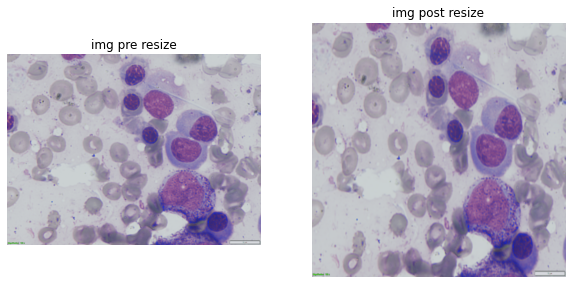

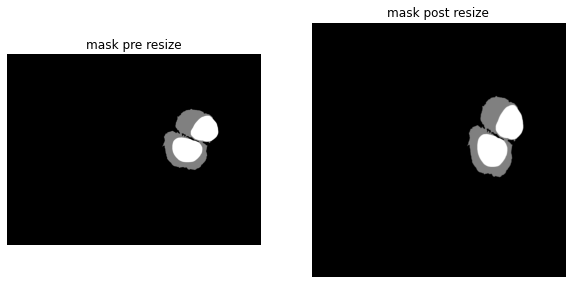

In [ ]:
# Estrazione di una casuale immagine di training
from random import randint

random_index = randint(0,len(tr_images)-1)
print(random_index)

figure=imread(tr_IMGS_path+'/'+tr_images[random_index])     #immagine presa a caso
resized_fig=X_train[random_index]                                #stessa immagine, resized
mask_fig=imagecodecs.imread(tr_MANU_path+'/'+tr_images[random_index])  #relativa maschera
print(mask_fig.shape)
if len(mask_fig.shape)>2:                                 # if there is more than 1 MM cell in the current image
    mask_fig = np.sum(mask_fig,2,np.uint8)                    # merge the N layers segmentation in a unique greyscale image
resized_mask=resize(mask_fig, [IMG_HEIGHT,IMG_WIDTH], preserve_range=True)
#resized_mask=Y_train[random_index,:,:,1]                         #bisogna mettere [random_index,:,:,1] perchè altrimenti
                                                                 #prende tutta la tupla Y_train[(indice, 512, 512, 2)]
                                                                 #con 2= canali che non possono essere plottati insieme
                                                                 #sceglo 1 perchè cosi mi plotta sfondo nero e oggetto bianco

print(resized_mask.shape)

#plot image
f1 = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(1, 2, 1)
pos1 = ax1.imshow(figure)
ax1.axis('off')
ax1.set_title("img pre resize")

ax2 = plt.subplot(1, 2, 2)
pos2 = ax2.imshow(resized_fig)
ax2.axis('off')
ax2.set_title("img post resize")

#plot mask
f2 = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(1, 2, 1)
pos1 = ax1.imshow(mask_fig, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title("mask pre resize")

ax2 = plt.subplot(1, 2, 2)
pos2 = ax2.imshow(resized_mask, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title("mask post resize")

Data augmentation

In [ ]:
# Data augmentation (training set)
image_datagen = ImageDataGenerator(rotation_range = 180,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode = 'reflect')

# Data augmentation (validation set)
val_datagen = ImageDataGenerator()

# Generator (NON TOCCARE LE RIGHE SOTTOSTANTI)
seed = 1
def XYaugmentGenerator(X1, y, seed, batch_size):
    genX1 = image_datagen.flow(X1, y, batch_size=batch_size, seed=seed)
    genX2 = image_datagen.flow(y, X1, batch_size=batch_size, seed=seed)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        yield X1i[0], X2i[0]


Definizione rete

In [ ]:
# Definizione del modello UNET
BACKBONE = 'resnet34'
model = Unet(backbone_name=BACKBONE,
            input_shape=(512,512,3),            #(altezza, larghezza, canali RGB)
            encoder_weights='imagenet',
            encoder_freeze=True,
            decoder_block_type='transpose',
            classes=2,
            activation='sigmoid')

# Definizione algoritmo di ottimizzazione e funzione di loss
model.compile('Adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

85524480/85521592 [==============================] - 1s 0us/step


Allenamento rete

In [ ]:
# Parametri della rete
n_train_samples = len(X_train) # numero delle immagini di train
n_val_samples = len(X_val)     # numero delle immagini di validation
batch_size = 8
n_epochs = 20

# Checkpoint definition
csv_logger = CSVLogger('./log.out', append=True, separator=';')
earlystopping = EarlyStopping(monitor = 'val_binary_accuracy',verbose = 1, min_delta = 0.01, patience = 2, mode = 'max')
callbacks_list = [csv_logger, earlystopping]

# Train model
results = model.fit_generator(XYaugmentGenerator(X_train,Y_train,seed, batch_size),
                              steps_per_epoch = np.ceil(float(len(X_train))/float(batch_size)),
                              validation_data = val_datagen.flow(X_val,Y_val,batch_size),
                              validation_steps = np.ceil(float(len(X_val))/float(batch_size)),
                              shuffle = True,
                              epochs = n_epochs,
                              callbacks = callbacks_list)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (300, 512, 512, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


38/38 [==============================] - 86s 2s/step - loss: 0.4091 - binary_accuracy: 0.8206 - val_loss: 0.9465 - val_binary_accuracy: 0.9070
Epoch 2/20
38/38 [==============================] - 53s 1s/step - loss: 0.2259 - binary_accuracy: 0.9004 - val_loss: 0.3920 - val_binary_accuracy: 0.9042
Epoch 3/20
38/38 [==============================] - 53s 1s/step - loss: 0.1945 - binary_accuracy: 0.9143 - val_loss: 0.2876 - val_binary_accuracy: 0.9195
Epoch 4/20
38/38 [==============================] - 53s 1s/step - loss: 0.1810 - binary_accuracy: 0.9191 - val_loss: 0.0945 - val_binary_accuracy: 0.9287
Epoch 5/20
38/38 [==============================] - 53s 1s/step - loss: 0.1763 - binary_accuracy: 0.9220 - val_loss: 0.1528 - val_binary_accuracy: 0.9301
Epoch 6/20
38/38 [==============================] - 53s 1s/step - loss: 0.1652 - binary_accuracy: 0.9271 - val_loss: 0.1935 - val_binary_accuracy: 0.9401
Epoch 7/20
38/38 [==============================] - 53s 1s/step - loss: 0.1660 - binary

testing rete

In [ ]:
# prendo il path del computer di colab cosi non usiamo la memoria di drive
path = os.getcwd()

# Path
TEST_IMG_path = os.path.join('test', 'images')
TEST_MASK_path = os.path.join('test', 'manual')

# Creare la cartella che conterrà i risultati della rete nel test set
path_results = 'testing_results'
if not os.path.exists(path + '/' + path_results):
  os.mkdir(path + '/' + path_results)

# Scorrere tutte le immagini del test set ed applicare la UNET
test_images = os.listdir(TEST_IMG_path)

performance=np.zeros([len(test_images),3])                                  #variabile per salvare le performance

for n, id_ in tqdm(enumerate(test_images), total=len(test_images)):

    # Load data
    img = imread(TEST_IMG_path+'/'+id_) #[:,:,:IMG_CHANNELS]
    img = resize(img, [IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS])
    img = img_as_ubyte(img)

    # Load manual mask
    mask = imagecodecs.imread(TEST_MASK_path+'/'+id_)
    print(f"mask shape: {mask.shape}")
    dim=mask.shape
    print(dim)
    if len(dim)>2:
      if mask.shape[2]>=1:
         mask = np.sum(mask,2,np.uint8)                     # merge the N layers segmentation in a unique greyscale image

    # Apply CNN for prediction
    img1 = np.reshape(img,(1,512,512,3))
    softmax = model.predict(img1)
    softmax = np.reshape(softmax,(512,512,2))
    softmax = resize(softmax, (450, 600), mode='constant', preserve_range=True)

    mask_auto = softmax[:,:,1]
    mask_auto[mask_auto<0.5]=0
    mask_auto[mask_auto>0.5]=255
    mask_auto = mask_auto.astype(np.uint8)

    # Save mask auto
    path_auto=os.path.join(path,path_results,id_)
    imsave(path_auto,mask_auto)

    #evaluating performances on i-th image and store the info(storing performances on each lesion could help to observe on which ones the CAD do not perform well)
    TP = (mask_auto*mask).sum()
    FP = (mask_auto*~mask).sum()
    FN = (~mask_auto*mask).sum()
    performance[n,0] = TP/(TP+FP)             #precision on i-th image
    performance[n,1] = TP/(TP+FN)             #recall on  i-th image
    performance[n,2] = 2*TP/(2*TP+FP+FN)     #F-SCORE on i-th image

  0%|          | 0/100 [00:00<?, ?it/s]


FileNotFoundError: ignored

In [ ]:
# Stampare una figura di debug, confrontando immagine originale, segmentazione
# manuale e segmentazione effettuata dalla UNET (per l'ultima immagine elaborata)
#path='/content/drive/MyDrive/eim/lab8/'

random_index = randint(0,len(test_images)-1)
print(random_index)

figura=imread(TEST_IMG_path+'/'+test_images[random_index])
maschera_man=imread(TEST_MASK_path+'/'+test_images[random_index])
maschera_auto=imread(path+'testing_results'+'/'+test_images[random_index])

fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(131)
ax1.imshow(figura), ax1.set_title('original image')
ax2 = fig.add_subplot(132)
ax2.imshow(maschera_man, cmap=plt.cm.gray), ax2.set_title('manual')
ax3 = fig.add_subplot(133)
ax3.imshow(maschera_auto, cmap=plt.cm.gray), ax3.set_title('automatic')

#print performances of CADe system
#print(f"\n\nperformances od CADe system across all the samples in the test set(printed as: precision|recall|F-SCORE)\n{perf}")  #uncomment to see performances on esch lesion
mean_perf = np.mean(performance, axis = 0)
print(f"\n\nmean performances of CADe system\nprecision: {mean_perf[0]} | recall: {mean_perf[1]} | F-SCORE: {mean_perf[2]}")